# 信号处理CFAR仿真

可以输入`bokeh serve --show arl.py --websocket-max-message-size 104857600 `来计算信道特性

In [10]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import librosa as lb
import arlpy.uwapm as pm
import arlpy.plot as aplt
# add/change bathy to env
import os
#os.environ["PATH"] += ":/Users/zanesing/Documents/at/Bellhop"
import cupy as cp
print(pm.models())
print(lb.__version__)

['bellhop']
0.10.2.post1


In [11]:
#TODO SSP
# add/change SSP to env
ssp = [                                 #Munk 声速刨面
  [  0.0 , 1548.52],[200.0 , 1530.29],[400.0 , 1517.78],[600.0 , 1509.49 ],  
  [800.0 , 1504.30],[1000.0 , 1501.38],[1200.0 ,1500.14],[1400.0 ,  1500.12],  
  [1600.0 ,1501.02],[1800.0 , 1502.57] , [2000.0 , 1504.62],[2200.0 , 1507.02 ],  
  [2400.0 , 1509.69 ],[2600.0 , 1512.55],[2800.0 , 1515.56],[3000.0 , 1518.67 ],
  [ 3200.0 , 1521.85 ],[3400.0 , 1525.10 ],[3600.0 , 1528.38],[3800.0 , 1531.70],
  [4000.0 , 1535.04],[4200.0 , 1538.39],[4400.0 , 1541.76 ],[4600.0 , 1545.14],
  [4800.0 , 1548.52 ],[5000.0 , 1551.91]
]

# Appending ssp and bathy to existing env file
env = pm.create_env2d(
    depth=5000,
    soundspeed=ssp,
    bottom_soundspeed=1551.91,
    bottom_density=1200,
    bottom_absorption=1.0,
    nbeams=70,
    tx_depth=200,
    rx_depth=400,
    frequency=1500,
    rx_range=500000
)

In [4]:
pm.plot_env(env, width=800)
rays = pm.compute_rays(env , debug=False)
pm.plot_rays(rays, env=env,width=900)

第一会聚区在60km处

    time_of_arrival  angle_of_arrival  surface_bounces  bottom_bounces
1         41.708763         21.637009                3               2
2         41.551460        -18.381254                2               2
3         39.980862         15.387637                2               1
4         39.905022        -13.932594                0               0
5         39.891445        -10.021035                0               0
6         39.881451         -7.421613                0               0
7         39.963970         14.300446                1               1
8         41.424187        -16.942045                1               2
9         41.628101         16.037951                2               2
10        41.642563         21.056229                2               2


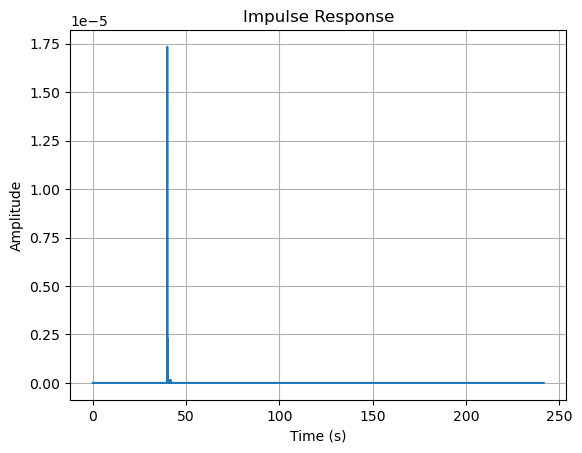

In [12]:
env['rx_range']=60000   #设置为60km
arrivals = pm.compute_arrivals(env)
pm.plot_arrivals(arrivals, width=900)
print(arrivals[arrivals.arrival_number < 10][['time_of_arrival', 'angle_of_arrival', 'surface_bounces', 'bottom_bounces']])

TIME=200
fs = 4000
env['rx_range']=60000   #set target to 60km 
arrivals = pm.compute_arrivals(env)
ir = pm.arrivals_to_impulse_response(arrivals, fs=fs,abs_time=True)
ir = np.concatenate([ir,np.zeros(int(TIME*fs))])
ir = cp.asarray(ir)

#aplt.plot(np.abs(ir), fs=4000, width=800) #有错误

"""Plot the impulse response."""
t = cp.arange(len(ir)) / fs
plt.figure()
plt.plot(t.get(), cp.abs(ir).get())
plt.xlabel('Time (s)');plt.ylabel('Amplitude');plt.title('Impulse Response')
plt.grid(True);plt.show()

## 生成信号

Generated m1:[0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1],m2:[0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1],m3:[0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1]


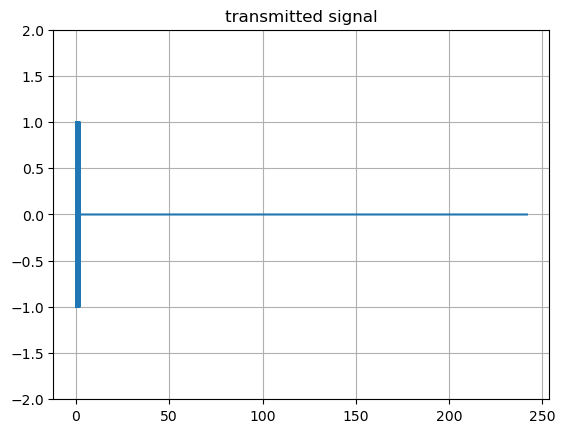

d:\anaconda3\.conda\envs\sig_processing\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


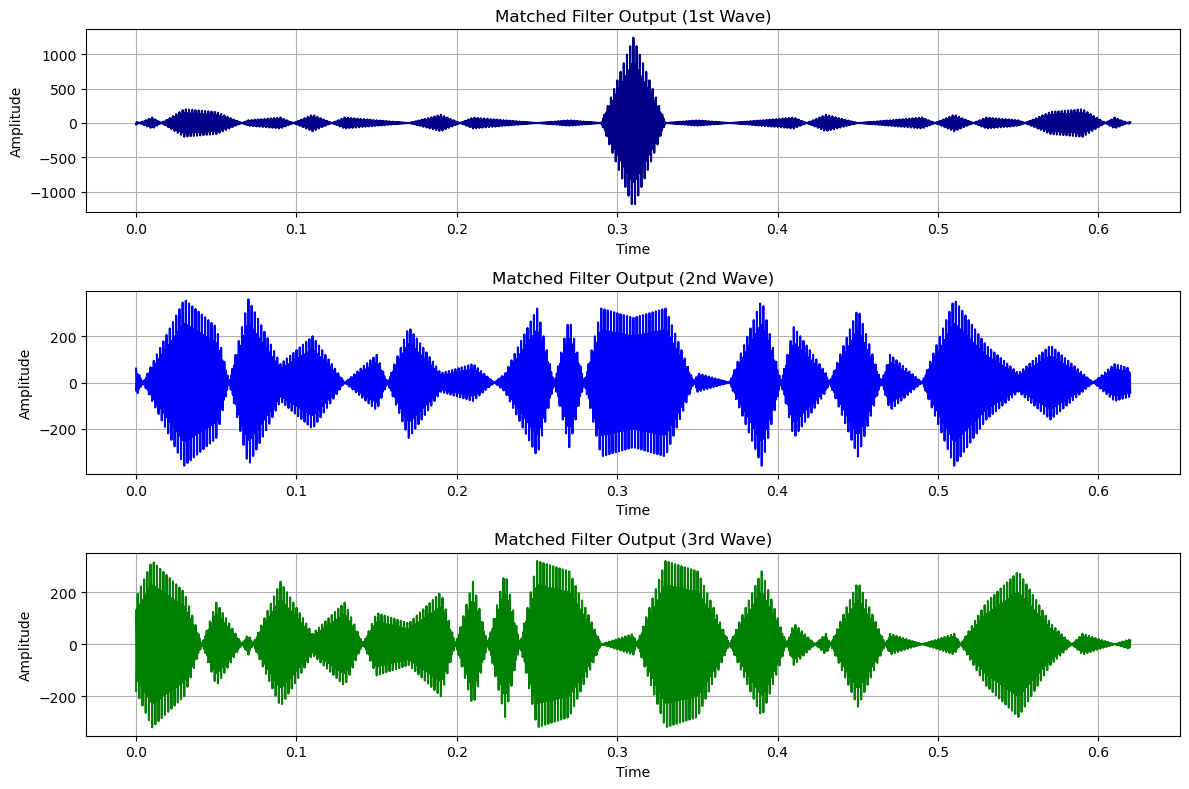

In [6]:
# 定义生成相位编码信号的函数
def generate_phase_encoded_signal(m_sequence, duration, f0, fs):
    t = cp.linspace(0, duration, int(duration * fs), endpoint=False)  # 时间轴
    # 初始化相位编码信号
    subpulse = cp.zeros_like(t)
    # 遍历 m-sequence，根据其值调整相位
    for i, bit in enumerate(m_sequence):
        start = int(i * len(t) / len(m_sequence))
        end = int((i + 1) * len(t) / len(m_sequence))
        if bit == 1:
            subpulse[start:end] = cp.cos(2 * cp.pi * f0 * t[start:end] + cp.pi)
        else:
            subpulse[start:end] = cp.cos(2 * cp.pi * f0 * t[start:end])
    template = subpulse[::-1]
    return subpulse , template

mseq1 = cp.asarray([0,0,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,1,1,1,0,1,0,1])
mseq2 = cp.asarray([0,0,0,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1])
mseq3 = cp.asarray([0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,1,1,0,1])
print(f"Generated m1:{ mseq1},m2:{ mseq2},m3:{ mseq3}")

# 参数配置
fs = 4000           # 采样率
duration = 0.62      # 单个子信号
f0 = 1500            # 频率范围

subpulse1,template = generate_phase_encoded_signal(mseq1,duration,f0,fs)
subpulse2,  _      = generate_phase_encoded_signal(mseq2,duration,f0,fs)
subpulse3,  _      = generate_phase_encoded_signal(mseq3,duration,f0,fs)


pulse = cp.concatenate([subpulse1,subpulse2,subpulse3])

num_pulse = 1      # 重复次数

#高效拼接多个Chirp（避免使用循环内concatenate）
Tx = cp.tile(pulse, num_pulse)  # 使用np.tile代替循环

#延长后补零
Tx_paddle = cp.concatenate([Tx,cp.zeros(len(ir)-len(Tx))])  #长度等于相响应长度


plt.figure
plt.title('transmitted signal')
plt.plot(t.get(),Tx_paddle.get())
plt.grid(True);plt.ylim(-2,2);plt.show()

#匹配滤波
from cupyx.scipy import signal
buffer =  pulse
test_t = cp.linspace(0,duration,len(subpulse1))
# 分别对每个子脉冲进行匹配滤波
buffer_out1 = signal.fftconvolve(subpulse1, template,mode='same')
buffer_out2 = signal.fftconvolve(subpulse2, template,mode='same')
buffer_out3 = signal.fftconvolve(subpulse3, template,mode='same')


# 绘制匹配滤波结果
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].plot(test_t.get(), buffer_out1.get(), color='darkblue')
axs[0].set_title('Matched Filter Output (1st Wave)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# 第二张子图：匹配滤波器输出（第一波）
axs[1].plot(test_t.get(), buffer_out2.get(), color='blue')
axs[1].set_title('Matched Filter Output (2nd Wave)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

# 第三张子图：另一个传输信号
axs[2].plot(test_t.get(), buffer_out3.get(), color='green')
axs[2].set_title('Matched Filter Output (3rd Wave)')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Amplitude')
axs[2].grid(True)

fig.tight_layout()


### 两次卷积计算回波

Length of transmitted signal:  966837
Length of first convolution result:  1933673
Length of second convolution result:  2900509


d:\anaconda3\.conda\envs\sig_processing\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda3\.conda\envs\sig_processing\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


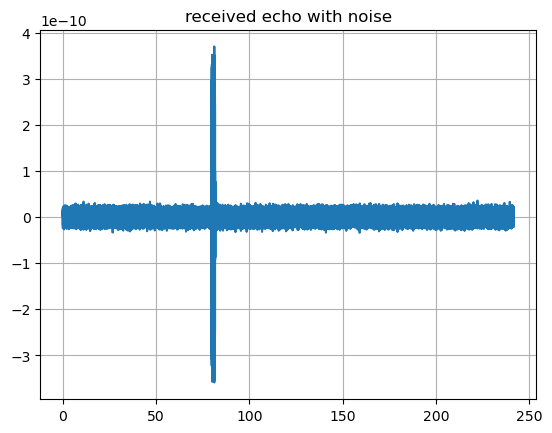

In [7]:
def awgn_gpu(signal, snr):
    signal_power = cp.sum(cp.abs(signal)**2) / len(signal)
    noise_power = signal_power / (10 ** (snr / 10))
    noise = cp.random.normal(0, cp.sqrt(noise_power), signal.shape)
    return signal + noise

#from scipy.signal import convolve
from cupyx.scipy.signal import convolve     

#TODO: 两次卷积计算回波信号
s = convolve( ir, Tx_paddle,mode='full')
Rx = convolve( ir,  s,mode='full')
        # optionally check the length of the results
print("Length of transmitted signal: ", len(Tx_paddle))
print("Length of first convolution result: ", len(s))
print("Length of second convolution result: ", len(Rx))
Rx = Rx[0:len(Tx_paddle)]

"""加入噪声"""
from modules.noise import awgn  #白噪声

Rx_noisy = awgn_gpu(Rx, snr=10)

plt.figure
plt.title('received echo with noise')
plt.plot(t.get(),Rx_noisy.get())
plt.grid(True)
plt.show()

### 经过带通滤波和匹配滤波

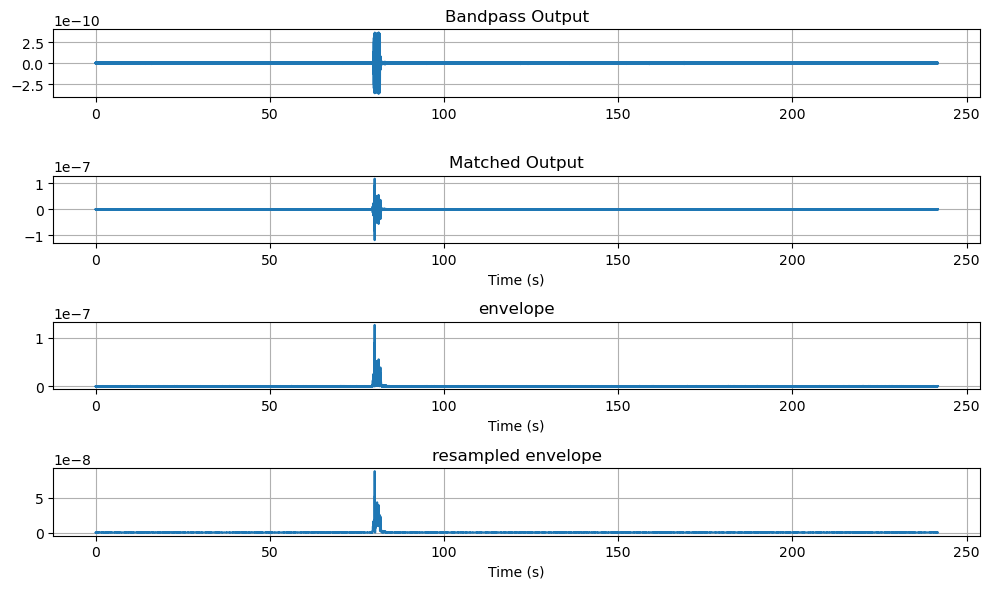

In [8]:
#TODO: 经过带通滤波器 和 匹配滤波器
from cupyx.scipy import signal     
# from scipy import signal     
from scipy.signal import butter,filtfilt
# 带通滤波器： 1350-1650Hz
fmax = fs/2
f_start ,f_end= 1350/fmax ,1650/fmax
b, a  =   butter( 8 , [ f_start , f_end ],  'bandpass' )    #配置滤波器 8 表示滤波器的阶数

BPF_out  =  filtfilt(b, a, cp.asnumpy(Rx_noisy))   #data为要过滤的信号
BPF_out =    cp.asarray(BPF_out)
# 匹配滤波：将输入信号与参考信号的时间反转版本进行卷积
matched_out = signal.fftconvolve(BPF_out, template, mode='same')

# 包络检波
analytic = signal.hilbert(matched_out.real)
envelope = np.abs(analytic)
#envelope /= np.max(envelope)

#降采样 ，采样率为原来的1/10
q = 100
envelope_res = signal.decimate(envelope,q, n=None, ftype='iir', axis=-1, zero_phase=True) 
fs_new = fs / q 
t_res = cp.arange(0, len(envelope_res)) / fs_new 
#绘制带通滤波后的信号波形
plt.figure(figsize=(10, 6))

# 上子图：带通滤波信号
plt.subplot(4, 1, 1)
plt.plot(t.get(), BPF_out.get());
plt.title('Bandpass Output');plt.grid(True)
# 下子图：匹配滤波信号
plt.subplot(4, 1, 2)
plt.plot(t.get(), matched_out.get())
plt.xlabel('Time (s)');plt.title('Matched Output')
plt.grid(True)
plt.tight_layout()
# 下子图：匹配滤波信号
plt.subplot(4, 1, 3)
plt.plot(t.get(), envelope.get())
plt.xlabel('Time (s)');plt.title('envelope')
plt.grid(True)
plt.tight_layout()

plt.subplot(4, 1, 4)
plt.plot(t_res.get(), envelope_res.get())
plt.xlabel('Time (s)');plt.title('resampled envelope')
plt.grid(True)
plt.tight_layout()

### 1D-CFAR

False


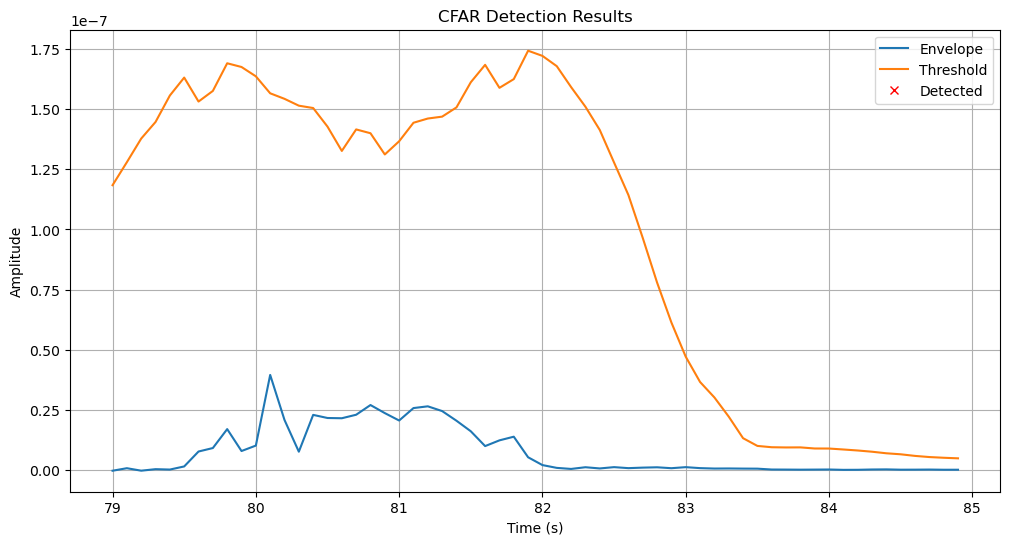

In [70]:
#TODO: 回波信号进行1D-CA-CFAR

def ca_cfar_1d_gpu(signal, guard_cells, train_cells, alpha):
    '''
    CA-CFAR算法
    '''
    N = len(signal)
    total_window = guard_cells + train_cells
    signal_ext = cp.pad(signal, (total_window, total_window), mode='constant')
    #信号的长度增加了 2 * total_window，
    #这样可以确保滑动窗口操作后的输出与输入信号的大小一致。
    
    # 创建滑动窗口
    window_size = 2 * total_window + 1
    windows = cp.lib.stride_tricks.sliding_window_view(signal_ext, window_size)
    
    # 提取训练区并计算均值
    left = windows[:, :train_cells]
    right = windows[:, -train_cells:]
    train = cp.concatenate((left, right), axis=1)
    noise_est = cp.mean(train, axis=1)
    
    # 计算阈值并比较
    thresholds = alpha * noise_est
    central = windows[:, train_cells+guard_cells]  # 中心点
    cfar_mask = (central > thresholds).astype(int)
    
    # 去除padding部分
    return cfar_mask[total_window:-total_window], thresholds

guard_len, train_len = 5, 10
P_f = 1e-5
alpha = 2 * (guard_len + train_len) * (P_f ** (-1/(2*(guard_len + train_len))) - 1)

cfar_mask , threshold= ca_cfar_1d_gpu(envelope_res, guard_cells=guard_len, train_cells=train_len, alpha=alpha)
detected_indices = np.where(cfar_mask == 1)[0]+ train_len+guard_len

    
    # 判断检测结果
real_start = 2*int(fs_new * cp.min(arrivals['time_of_arrival']) )+random_num//q
real_end = 2*int(fs_new * cp.max(arrivals['time_of_arrival'])) +random_num//q
success = cp.any((detected_indices >= real_start) & (detected_indices <= real_end))
print(success)
# 绘制回波信号和检测结果
# 选择绘图的时间范围
start_index,end_index = int(79 * fs_new),int(88 * fs_new)
# 找到在绘图范围内的检测到的索引
detected_in_range = detected_indices[(detected_indices >= start_index) & (detected_indices <= end_index)]
plt.figure(figsize=(12, 6))
plt.plot(t_res[int(fs_new*79):int(fs_new*85)].get(), envelope_res[int(fs_new*79):int(fs_new*85)].get(), label='Envelope')
plt.plot(t_res[int(fs_new*79):int(fs_new*85)].get(), threshold[int(fs_new*79):int(fs_new*85)].get(), label='Threshold')
plt.plot(t_res[detected_in_range].get(), envelope_res[detected_in_range].get(), 'rx', label='Detected')  # 使用红色圆点标记检测到的点


plt.title('CFAR Detection Results')
plt.xlabel('Time (s)');plt.ylabel('Amplitude')
plt.legend();plt.grid(True)

### 2D-CFAR
#### RDM

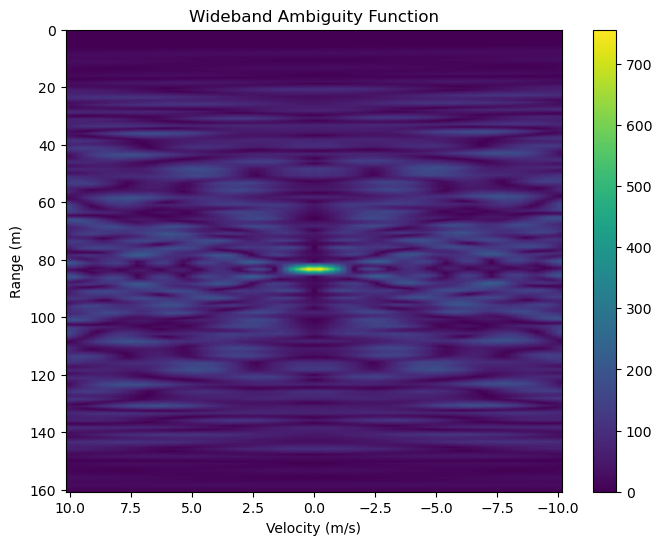

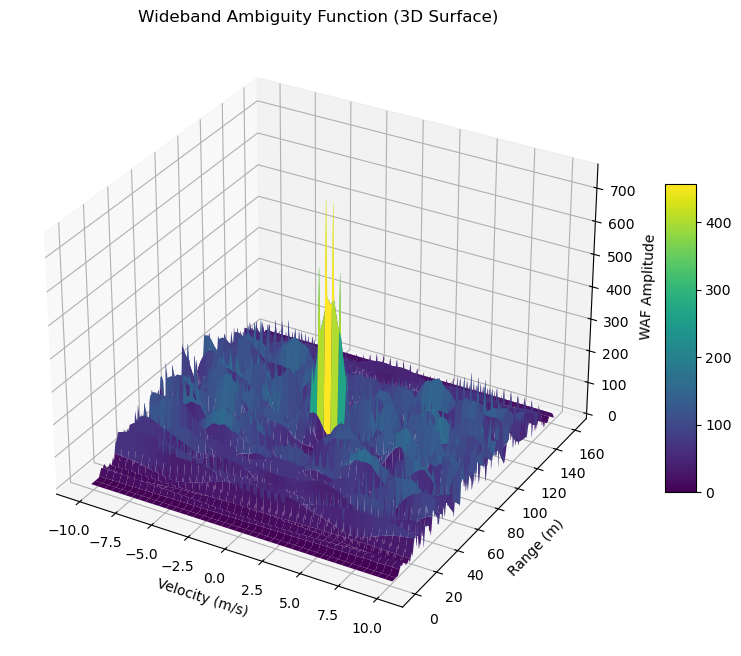

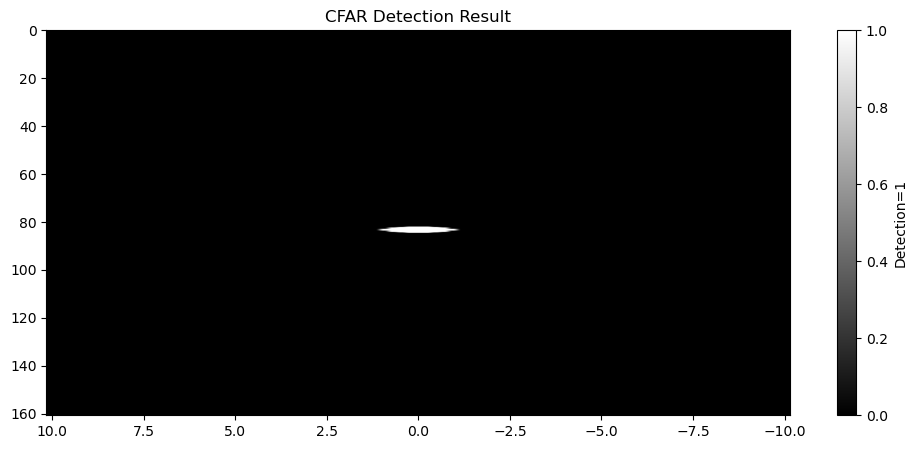

In [9]:
def generate_phase_encoded_signal(m_sequence, duration, f0, fs):
    t = cp.linspace(0, duration, int(duration * fs), endpoint=False)  # 时间轴
    # 初始化相位编码信号
    subpulse = cp.zeros_like(t)
    # 遍历 m-sequence，根据其值调整相位
    for i, bit in enumerate(m_sequence):
        start = int(i * len(t) / len(m_sequence))
        end = int((i + 1) * len(t) / len(m_sequence))
        if bit == 1:
            subpulse[start:end] = cp.cos(2 * cp.pi * f0 * t[start:end] + cp.pi)
        else:
            subpulse[start:end] = cp.cos(2 * cp.pi * f0 * t[start:end])
    template = subpulse[::-1]
    return subpulse , template

# 参数配置
fs = 4000           # 采样率
duration = 0.62      # 单个子信号
f0 = 1500            # 频率范围

mseq1 = cp.asarray([0,0,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,1,1,1,0,1,0,1])
mseq2 = cp.asarray([0,0,0,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1])
subpulse1,template = generate_phase_encoded_signal(mseq1,duration,f0,fs)
subpulse2,  _      = generate_phase_encoded_signal(mseq2,duration,f0,fs)


from modules.waf import wideband_ambiguity
WAF, velocity_axis, range_axis = wideband_ambiguity(cp.asnumpy(subpulse1), cp.asnumpy(subpulse1),
                                                                 r=50, b=2, length=7, c=1500,
                                                                 max_velocity=10, target_distance=1000, fs=fs)

plt.figure(figsize=(8, 6))
# 用 extent 指定 x 轴为 velocity，y 轴为 range（距离），这里 range_axis 的最大值对应图像的高度
plt.imshow(WAF, aspect='auto', extent=[velocity_axis[-1], velocity_axis[0], range_axis[-1], range_axis[0]])
plt.xlabel("Velocity (m/s)")
plt.ylabel("Range (m)")
plt.title("Wideband Ambiguity Function")
plt.colorbar() 
plt.show()


from mpl_toolkits.mplot3d import Axes3D
X, Y = np.meshgrid(velocity_axis, range_axis)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, WAF, cmap='viridis')

ax.set_xlabel("Velocity (m/s)")
ax.set_ylabel("Range (m)")
ax.set_zlabel("WAF Amplitude")
ax.set_title("Wideband Ambiguity Function (3D Surface)")

# 添加 colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# 应用2D CA-CFAR
from modules.cfar import ca_cfar_2d
cfar_mask_2d = ca_cfar_2d(WAF, guard_cells=10, train_cells=20, alpha=4)
det_r, det_d = np.where(cfar_mask_2d==1)

# 可视化2D结果
plt.figure(figsize=(12,5))
plt.title('CFAR Detection Result')
plt.imshow(cfar_mask_2d, cmap='gray', aspect='auto', extent=[velocity_axis[-1], velocity_axis[0], range_axis[-1], range_axis[0]])
plt.colorbar(label='Detection=1')
plt.show()

## 绘制性能图片

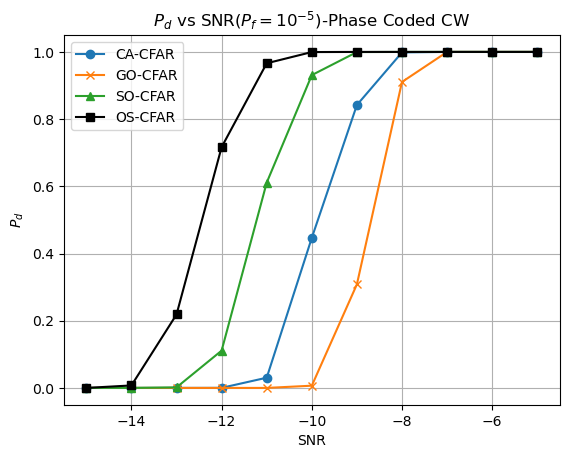

In [82]:
import matplotlib.pyplot as plt

# 定义不同算法的数据
ca_cfar = [0.0000, 0.0000, 0.0000, 0.0002, 0.0304, 0.4466, 0.8420, 0.9986, 1.0000, 1.0000, 1.0000]
go_cfar = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0066, 0.3082, 0.9106, 1.0000, 1.0000, 1.0000]
so_cfar = [0.0000, 0.0000, 0.0016, 0.1110, 0.6110, 0.9310, 0.9996, 1.0000, 1.0000, 1.0000, 1.0000]
os_cfar = [0.0000, 0.0074, 0.2186, 0.7166, 0.9662, 0.9996, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]

# 定义横坐标SNR的值
snr = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5]

# 绘制图形
plt.plot(snr, ca_cfar,'o-', label='CA-CFAR')
plt.plot(snr, go_cfar,'x-', label='GO-CFAR')
plt.plot(snr, so_cfar,'^-',label='SO-CFAR')
plt.plot(snr, os_cfar,'ks-',label='OS-CFAR')

# 添加标题和轴标签
plt.title('$P_d$ vs SNR($P_f=10^{-5}$)-Phase Coded CW')
plt.xlabel('SNR')
plt.ylabel('$P_d$')

# 添加图例
plt.legend();plt.grid(True)
plt.show()